In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.patches as mpatches
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("linear_model.txt",delimiter='\t',header=None)
data.columns=['x','y','dy']

In [3]:
def f(x,a,b):
    return a*np.cos(x)+b
def f1(x,a,b,c):
    return a*np.cos(x+c)+b

popt, pcov = curve_fit(f,data['x'].values,data['y'].values,p0=[2,2],sigma=data['dy'].values)
popt1, pcov1 = curve_fit(f1,data['x'].values,data['y'].values,p0=[2,2,0],sigma=data['dy'].values)

In [4]:
model = sp.CmdStanModel(stan_file='./stan_file.stan')
print(model.code())

INFO:cmdstanpy:compiling stan program, exe file: /Users/jakob/Documents/Studium/master_thesis/bayes/first_model/stan_file
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /Users/jakob/Documents/Studium/master_thesis/bayes/first_model/stan_file


data {
	int<lower=0> n;
	vector[n] x;
	vector[n] y;
	vector[n] dy;
}
parameters {
	real a;
	real b;
}

model {
	y ~ normal(b + a * cos(x), dy);
	a ~ normal(0,100);
	b ~ normal(0,100);
}
generated quantities {
	real y_tilde[n] = normal_rng(b + a * cos(x),dy);
	vector[n] log_lik;
	vector[n] mu;
	mu=b+a*cos(x);
	for (k in 1:n){
    	log_lik[k]=normal_lpdf(y[k]|mu[k], dy[k]);
    }
}



In [5]:
stan_data={'n':len(data['x'].values),
             'x':list(data['x'].values),
             'y':list(data['y'].values),
           'dy':list(data['dy'].values)
}

fit = model.sample(data=stan_data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3


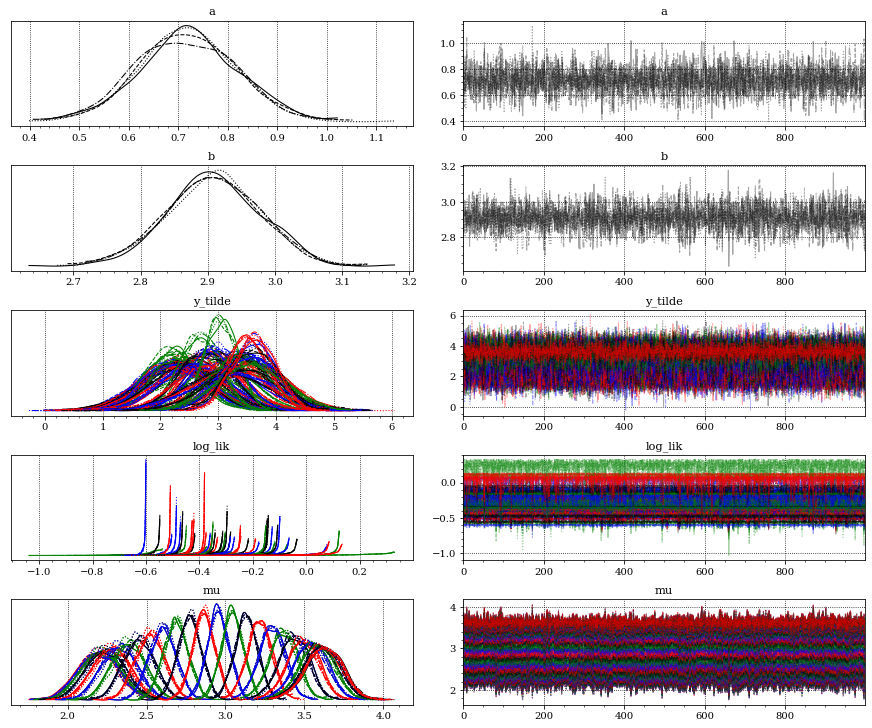

In [6]:
%%capture --no-display
warnings.filterwarnings('ignore')
az.plot_trace(fit)
plt.show()

In [7]:
samples=fit.draws_pd()
samples

lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0    -2.096130       0.835052    0.977814          1.0           1.0   
1    -1.647280       1.000000    0.977814          2.0           3.0   
2    -0.760358       0.976489    0.977814          2.0           3.0   
3    -1.203550       0.863085    0.977814          2.0           3.0   
4    -1.987190       0.686599    0.977814          2.0           3.0   
...        ...            ...         ...          ...           ...   
3995 -1.335470       0.998658    0.852481          2.0           7.0   
3996 -1.047370       0.953787    0.852481          2.0           3.0   
3997 -5.579960       0.583593    0.852481          2.0           3.0   
3998 -0.886391       1.000000    0.852481          2.0           3.0   
3999 -1.788440       0.908598    0.852481          2.0           3.0   

      divergent__  energy__         a        b  y_tilde[1]  ...   mu[41]  \
0             0.0   2.16522  0.680972  2.79737     3.69190  ...  3.00780   
1             0.0   2.24445  0.808288  2.97417     3.20647  ...  3.22394   
2             0.0   1.83093  0.747440  2.91712     3.60633  ...  3.14809   
3             0.0   1.98737  0.616317  2.92201     3.18853  ...  3.11247   
4             0.0   3.30381  0.778441  3.00811     2.67174  ...  3.24866   
...           ...       ...       ...      ...         ...  ...      ...   
3995          0.0   1.81815  0.740353  2.98428     3.49253  ...  3.21306   
3996          0.0   1.98965  0.736246  2.85149     3.35157  ...  3.07900   
3997          0.0   6.01493  0.405612  2.94476     3.52564  ...  3.07010   
3998          0.0   5.04832  0.683640  2.94727     4.02432  ...  3.15853   
3999          0.0   1.94901  0.861978  2.88949     3.75299  ...  3.15585   

       mu[42]   mu[43]   mu[44]   mu[45]   mu[46]   mu[47]   mu[48]   mu[49]  \
0     3.08731  3.16225  3.23144  3.29378  3.34829  3.39411  3.43052  3.45695   
1     3.31832  3.40727  3.48939  3.56339  3.62809  3.68248  3.72570  3.75706   
2     3.23536  3.31761  3.39355  3.46198  3.52181  3.57210  3.61207  3.64107   
3     3.18443  3.25225  3.31487  3.37129  3.42062  3.46210  3.49505  3.51897   
4     3.33955  3.42522  3.50430  3.57556  3.63788  3.69026  3.73188  3.76209   
...       ...      ...      ...      ...      ...      ...      ...      ...   
3995  3.29951  3.38098  3.45620  3.52398  3.58324  3.63306  3.67264  3.70138   
3996  3.16497  3.24599  3.32079  3.38819  3.44712  3.49667  3.53603  3.56460   
3997  3.11746  3.16210  3.20331  3.24044  3.27291  3.30020  3.32189  3.33763   
3998  3.23835  3.31359  3.38304  3.44563  3.50035  3.54635  3.58291  3.60944   
3999  3.25650  3.35136  3.43893  3.51784  3.58684  3.64484  3.69093  3.72438   

       mu[50]  
0     3.47297  
1     3.77608  
2     3.65866  
3     3.53347  
4     3.78041  
...       ...  
3995  3.71880  
3996  3.58193  
3997  3.34717  
3998  3.62552  
3999  3.74467  

[4000 rows x 159 columns]

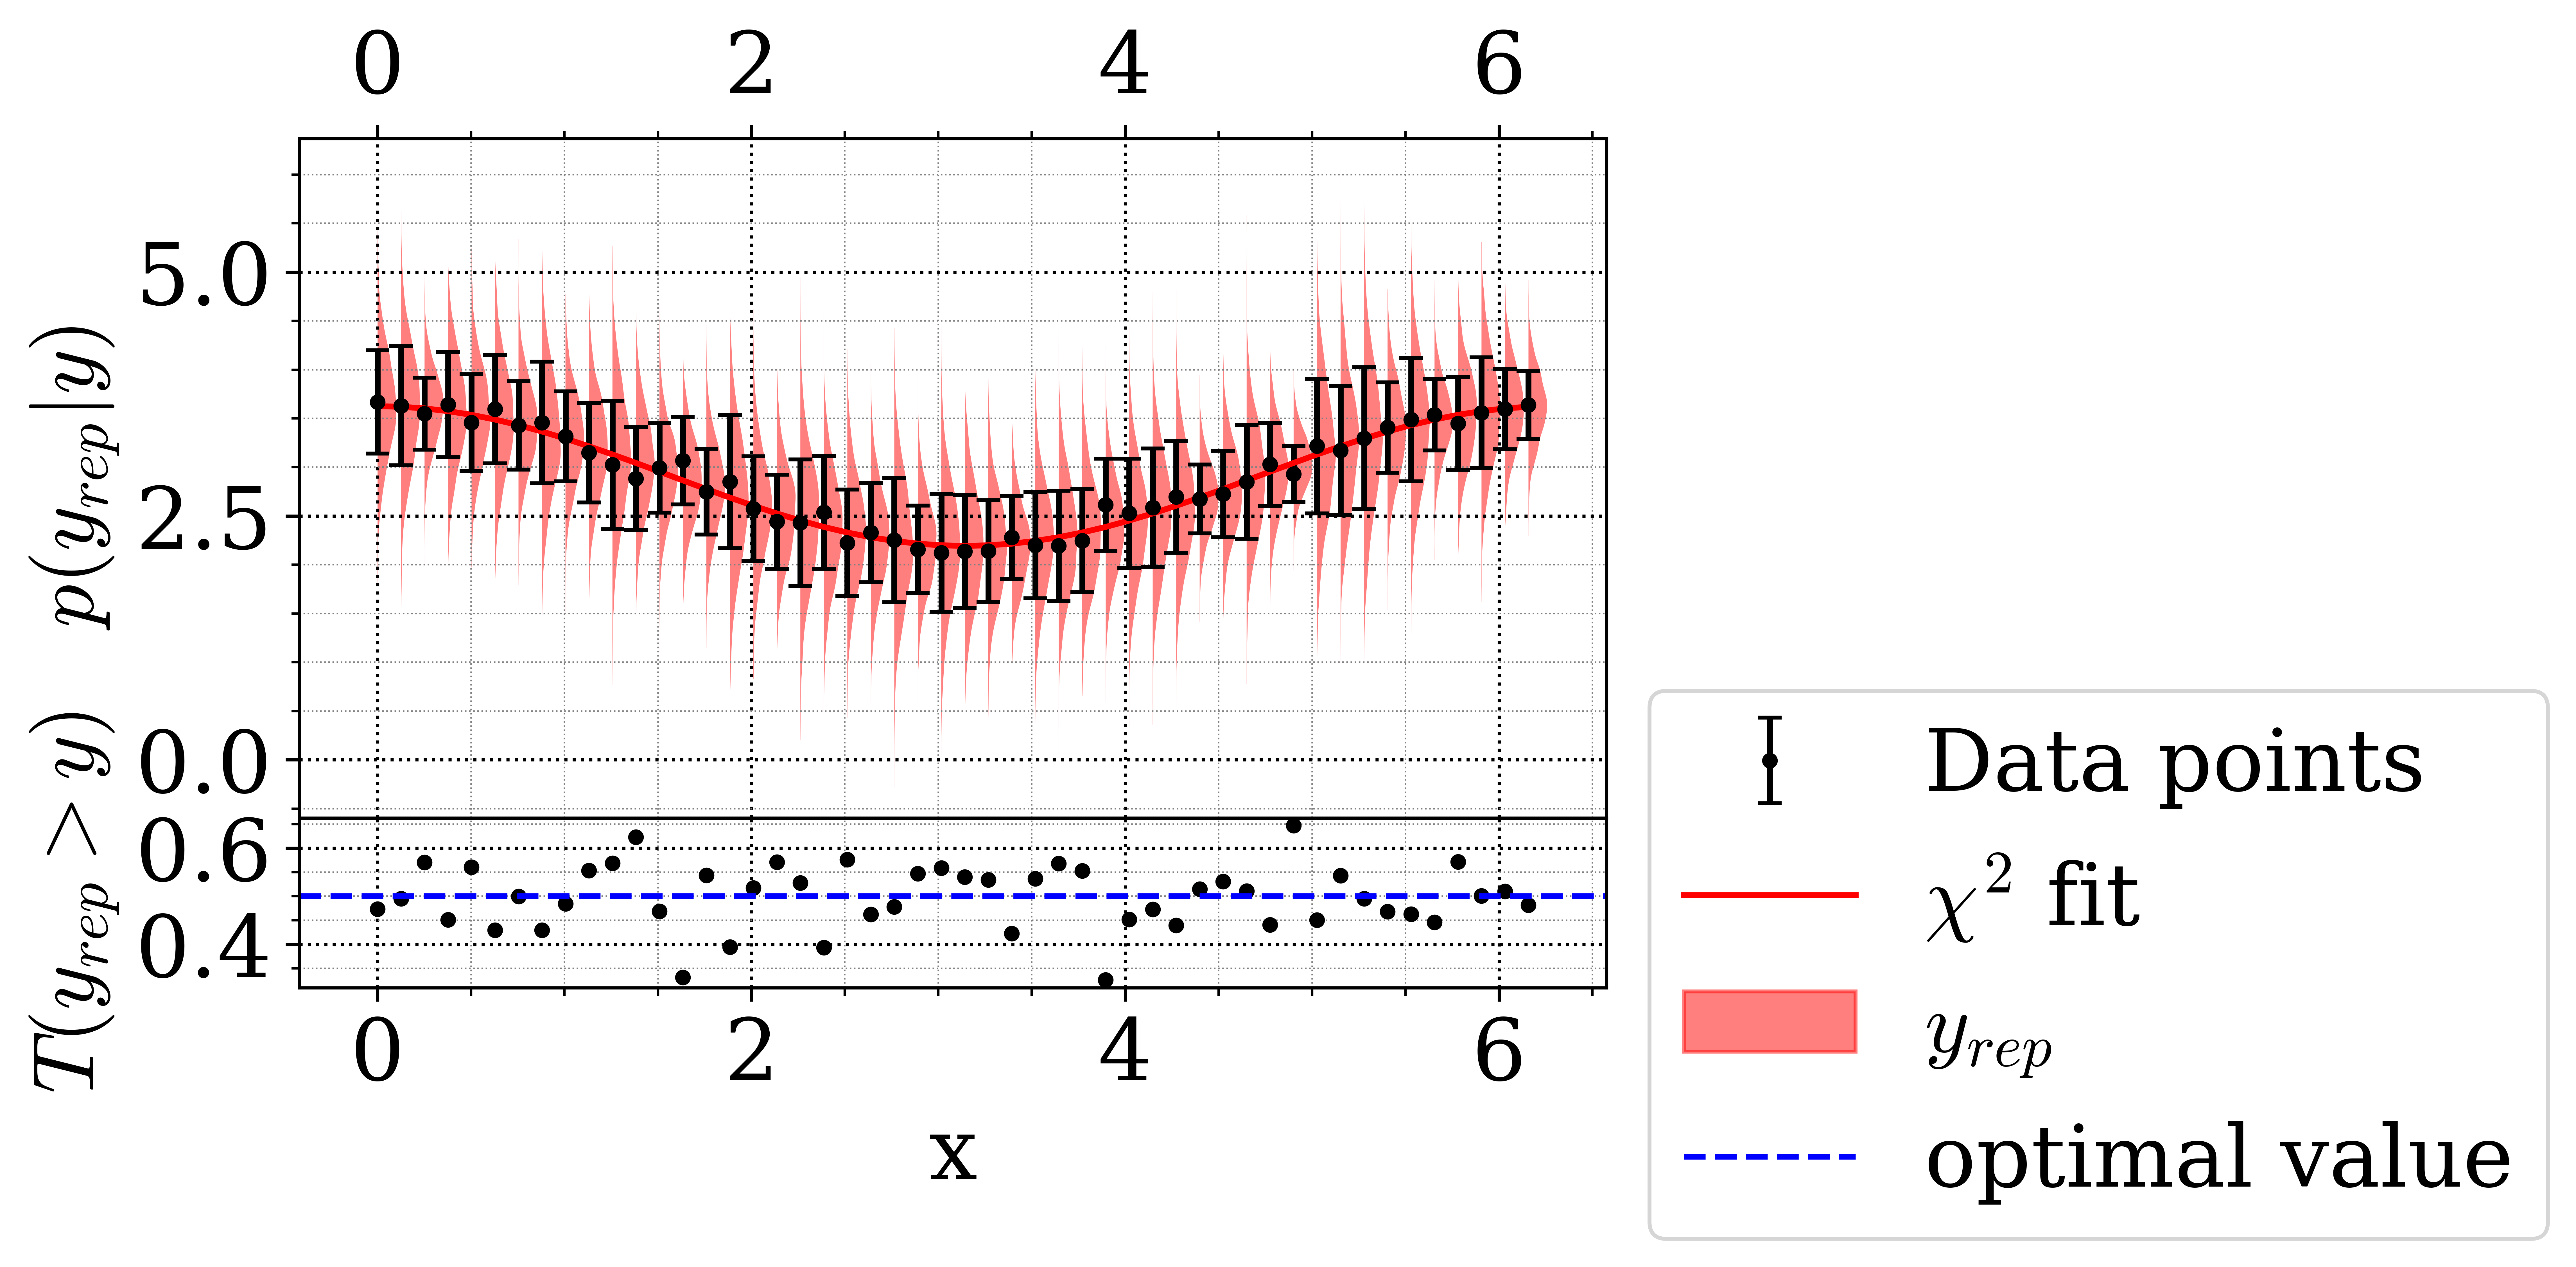

In [8]:
#cosmetics
fig, (ax, ax1)=plt.subplots(nrows=2,sharex=True,dpi=1000,gridspec_kw={'height_ratios': [4, 1]})
ax.set_ylabel('$p(y_{rep}|y)$')
ax.xaxis.set_ticks_position("top")
ax.grid(which='minor',color='grey',lw='.4')
#get results from chisq fit and plot them
yfit=f(data['x'],*popt)
ax.errorbar(x=data['x'],y=data['y'],yerr=data['dy'],fmt='.',label='Data points')
#ax.plot(data['x'],data['y'],'x',label='Data points')
ax.plot(data['x'],yfit,'r-',label='$\chi^2$ fit',color='r')
#violinplot for the replicated samples
vp=ax.violinplot([samples[f'y_tilde[{i+1}]']for i in range(50)],data['x'],showmeans=False, showextrema=False, showmedians=False,widths=0.2)
#cosmetics
for b in vp['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_alpha(.5)
    #b.set_color('red')

#compute p value as measure of goodness of fit
y_arr=[samples[f'y_tilde[{i+1}]']for i in range(50)]
pvalue=[len([y for y in y_arr[i] if y>=data['y'][i]])/len(y_arr[i])for i in range(50)]
#plot pvalue
ax1.grid(which='minor',color='grey',lw='.4')
ax1.plot(data['x'],pvalue,'.')
ax1.axhline(y=0.5, color='b', linestyle='--',label='optimal value')
ax1.set_xlabel('x')
ax1.set_ylabel('$T(y_{rep}>y)$')
#cosmetics and legend
plt.subplots_adjust(wspace=0, hspace=0)
lines,labels = ax.get_legend_handles_labels() 
patch = mpatches.Patch(color='red', label='$y_{rep}$',alpha=.5)
lines.append(patch)
lines1,labels1=ax1.get_legend_handles_labels()
lines+=lines1
tmp=lines[0]
lines[0]=lines[1]
lines[1]=tmp
plt.legend(handles=lines,bbox_to_anchor=(1,2))
plt.savefig('plot.pdf',format='pdf',bbox_inches='tight',dpi=1000)


(array([ 2.,  0.,  3.,  8.,  9.,  8.,  8., 10.,  0.,  2.]),
 array([0.326 , 0.3581, 0.3902, 0.4223, 0.4544, 0.4865, 0.5186, 0.5507,
        0.5828, 0.6149, 0.647 ]),
 <BarContainer object of 10 artists>)

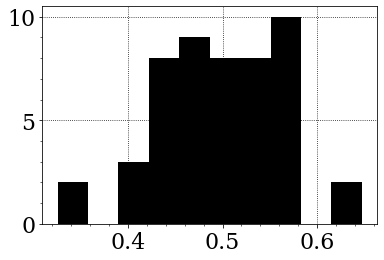

In [9]:
plt.hist(pvalue)

In [10]:
pwaic=sum([np.var(samples[f'log_lik[{i+1}]'], ddof=1)for i in range(50)])
lpd=sum([np.log(np.mean(np.exp(samples[f'log_lik[{i+1}]'])))for i in range(50)])
print(lpd-pwaic)

-14.398278427949466


In [11]:
print(pwaic)

0.10502641653683338


In [12]:
model1= sp.CmdStanModel(stan_file='./stan_file1.stan')
fit1 = model1.sample(data=stan_data)
fit1.summary()
samples1=fit1.draws_pd()

INFO:cmdstanpy:compiling stan program, exe file: /Users/jakob/Documents/Studium/master_thesis/bayes/first_model/stan_file1
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /Users/jakob/Documents/Studium/master_thesis/bayes/first_model/stan_file1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1


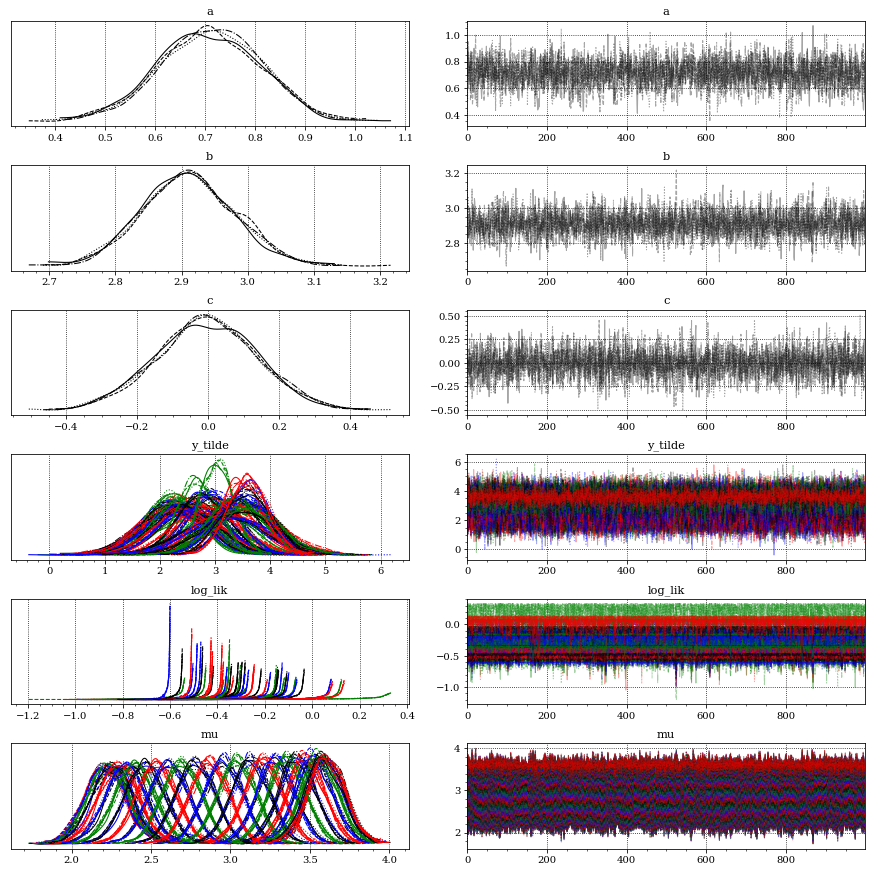

In [13]:
az.plot_trace(fit1)
plt.show()

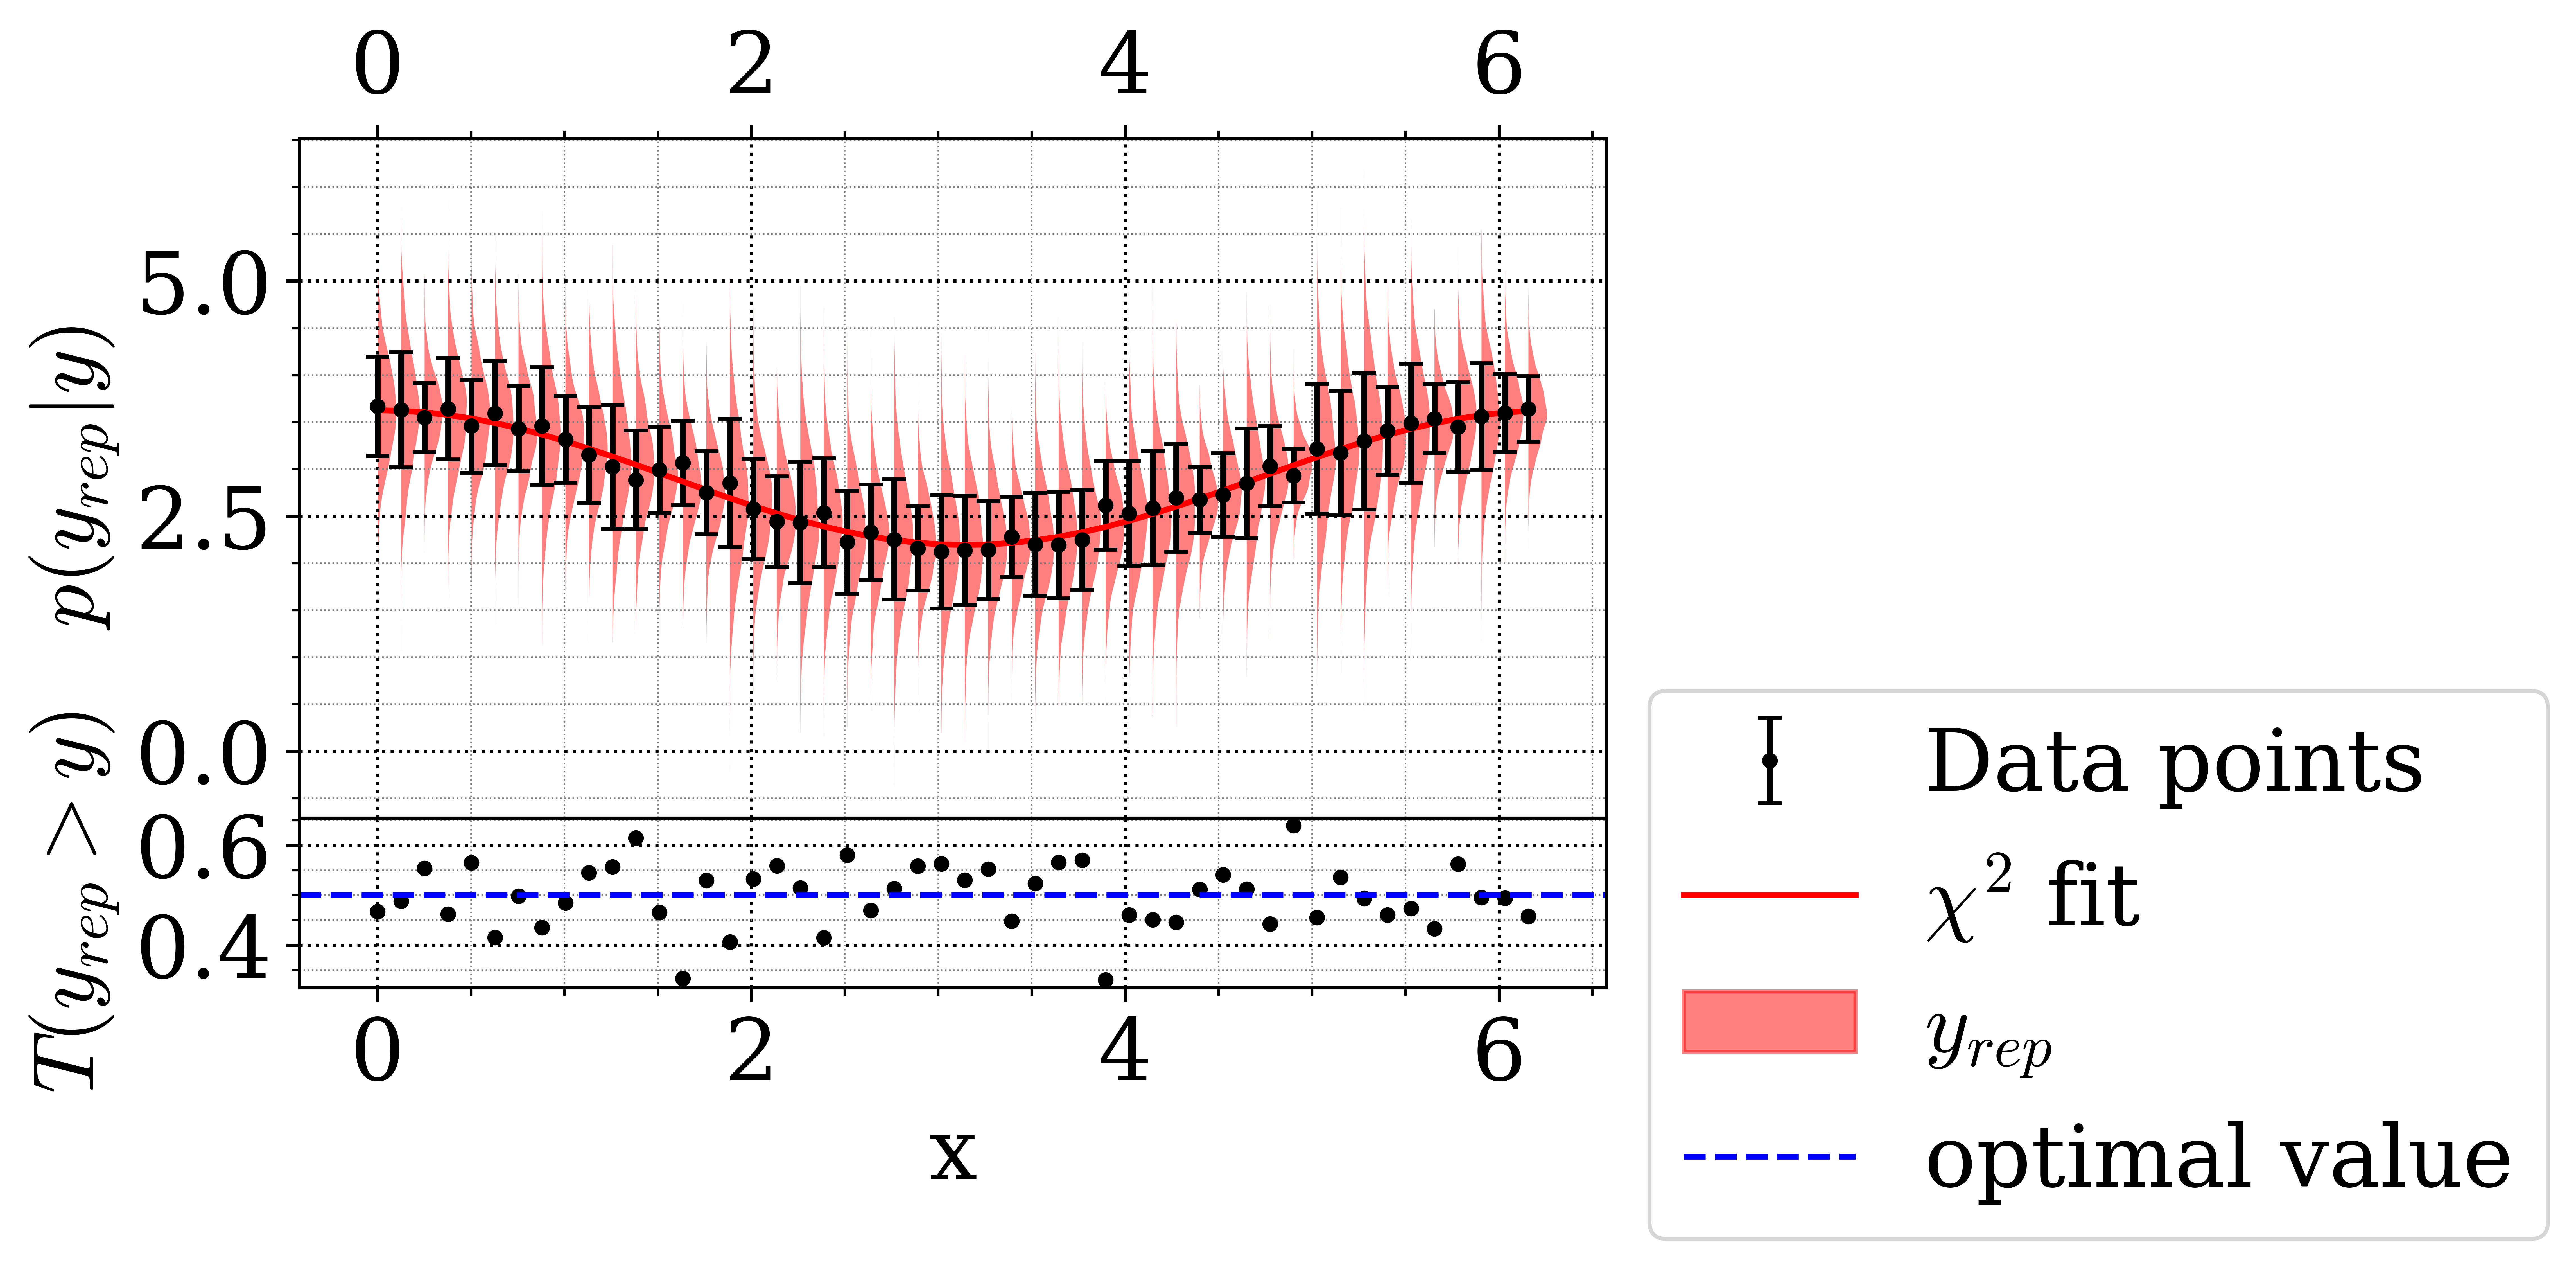

In [14]:
#cosmetics
fig, (ax, ax1)=plt.subplots(nrows=2,sharex=True,dpi=1000,gridspec_kw={'height_ratios': [4, 1]})
ax.set_ylabel('$p(y_{rep}|y)$')
ax.xaxis.set_ticks_position("top")
ax.grid(which='minor',color='grey',lw='.4')
#get results from chisq fit and plot them
yfit1=f1(data['x'],*popt1)
ax.errorbar(x=data['x'],y=data['y'],yerr=data['dy'],fmt='.',label='Data points')
#ax.plot(data['x'],data['y'],'x',label='Data points')
ax.plot(data['x'],yfit1,'r-',label='$\chi^2$ fit',color='r')
#violinplot for the replicated samples
vp=ax.violinplot([samples1[f'y_tilde[{i+1}]']for i in range(50)],data['x'],showmeans=False, showextrema=False, showmedians=False,widths=0.2)
#cosmetics
for b in vp['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_alpha(.5)
    #b.set_color('red')

#compute p value as measure of goodness of fit
y_arr=[samples1[f'y_tilde[{i+1}]']for i in range(50)]
pvalue=[len([y for y in y_arr[i] if y>=data['y'][i]])/len(y_arr[i])for i in range(50)]
#plot pvalue
ax1.grid(which='minor',color='grey',lw='.4')
ax1.plot(data['x'],pvalue,'.')
ax1.axhline(y=0.5, color='b', linestyle='--',label='optimal value')
ax1.set_xlabel('x')
ax1.set_ylabel('$T(y_{rep}>y)$')
#cosmetics and legend
plt.subplots_adjust(wspace=0, hspace=0)
lines,labels = ax.get_legend_handles_labels() 
patch = mpatches.Patch(color='red', label='$y_{rep}$',alpha=.5)
lines.append(patch)
lines1,labels1=ax1.get_legend_handles_labels()
lines+=lines1
tmp=lines[0]
lines[0]=lines[1]
lines[1]=tmp
plt.legend(handles=lines,bbox_to_anchor=(1,2))
plt.savefig('plot1.pdf',format='pdf',bbox_inches='tight',dpi=1000)

In [15]:
pwaic1=sum([np.var(samples1[f'log_lik[{i+1}]'], ddof=1)for i in range(50)])
lpd1=sum([np.log(np.mean(np.exp(samples1[f'log_lik[{i+1}]'])))for i in range(50)])
print(lpd1-pwaic1)

-14.983680788605747
